In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd  'drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [4]:
#Import library
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [5]:
#Load dataset
train_df = pd.read_csv("/content/drive/MyDrive/jigsaw/Suturing/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/jigsaw/Suturing/test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 26
Total videos for testing: 11


,video_name,tag
3,Suturing_C001_capture1.avi,I
4,Suturing_C002_capture1.avi,I
19,Suturing_G003_capture1.avi,N
14,Suturing_F001_capture1.avi,I
16,Suturing_F003_capture1.avi,I
21,Suturing_H001_capture1.avi,N
20,Suturing_G004_capture1.avi,N
13,Suturing_E004_capture1.avi,E
1,Suturing_B004_capture1.avi,N
17,Suturing_G001_capture1.avi,N


In [6]:
train_df.dtypes

video_name    object
tag           object
dtype: object

In [7]:
# Mendefenisikan hyperparameter
IMG_SIZE = 224 
BATCH_SIZE = 20
EPOCHS = 100

MAX_SEQ_LENGTH = 500 #Maksimal jumlah frame yang akan dipakai 
NUM_FEATURES = 2048

In [8]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


In [9]:
#Feature extraction bermekanisme transfer learning pakai CNN(Inception V3)
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 1s 0us/step


In [10]:
# Transformasi label tag(label_processor)
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['E', 'I', 'N']


In [11]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` dan `frame_features` sebagai input ke dalam sequence model.
    # Akan diisi 0 jika jumlah frame < Max_Seq_length
    # `frame_masks` akan berisi boolean yang akan menunjukkan apakah timestamp ditutup dengan padding atau tidak
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # Untuk setiap video
    for idx, path in enumerate(video_paths):
        # Mengumpulkan semua frame dan menambahkan batch dimensionnya.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Inisialisasi placeholder untuk menyimpan masks dan features video saat ini
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Mengekstraksi feature dari video saat ini
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "/content/drive/MyDrive/jigsaw/Suturing/train")
test_data, test_labels = prepare_all_videos(test_df, "/content/drive/MyDrive/jigsaw/Suturing/test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step
Frame features in train set: (26, 500, 2048)
Frame masks in train set: (26, 500)


In [12]:
from tensorflow.keras import layers, optimizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GRU, Input, Dense, Dropout
NUM_CLASSES = 3
DROPOUT_RATE = 0.1

class_vocab = label_processor.get_vocabulary()

frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

# LSTM layers
lstm2 = tf.keras.layers.LSTM(16, return_sequences=True)(
    frame_features_input, mask=mask_input
)
x = tf.keras.layers.LSTM(8)(lstm2)

# Classification layers
dense1 = Dropout(DROPOUT_RATE)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense1)

model = keras.Model([frame_features_input, mask_input], outputs)

# Menentukan optimizer dan loss function
adam = optimizers.Adam(lr=0.0001)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
)

# Train model
history = model.fit(
    [train_data[0], train_data[1]],
    train_labels,
    validation_split=0.2,
    epochs=EPOCHS
)

# Evaluasi model
test_loss, test_accuracy = model.evaluate([train_data[0], train_data[1]],train_labels)
print('Test accuracy:', test_accuracy)

Epoch 1/100
1/1 [==============================] - 15s 15s/step - loss: 1.1649 - accuracy: 0.3000 - val_loss: 1.2337 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 152ms/step - loss: 1.0780 - accuracy: 0.3500 - val_loss: 1.1928 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 155ms/step - loss: 1.0430 - accuracy: 0.4500 - val_loss: 1.1699 - val_accuracy: 0.1667
Epoch 4/100
1/1 [==============================] - 0s 173ms/step - loss: 0.9752 - accuracy: 0.5000 - val_loss: 1.2245 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 148ms/step - loss: 0.8903 - accuracy: 0.8000 - val_loss: 1.2435 - val_accuracy: 0.1667
Epoch 6/100
1/1 [==============================] - 0s 172ms/step - loss: 0.8853 - accuracy: 0.7000 - val_loss: 1.2475 - val_accuracy: 0.1667
Epoch 7/100
1/1 [==============================] - 0s 152ms/step - loss: 0.8732 - accuracy: 0.7000 - val_loss: 1.2766 - val_accuracy: 0.1667
Ep

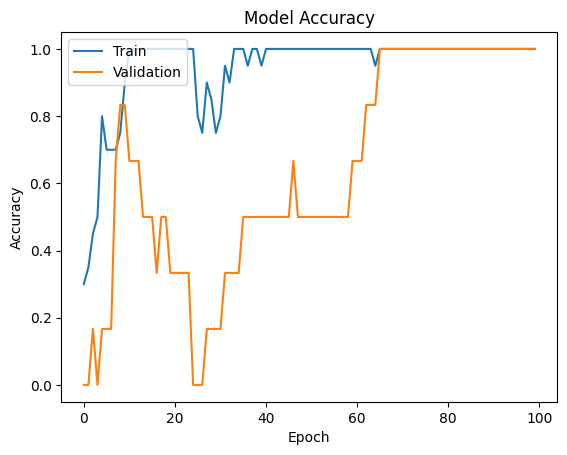

In [13]:
import matplotlib.pyplot as plt


# plot training and validation accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
import numpy as np
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("/content/drive/MyDrive/jigsaw/Suturing/test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# Visualization
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=25)
    return embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)


Test video path: Suturing_B002_capture1.avi
1/1 [==============================] - 2s 2s/step
  N: 77.55%
  E: 15.57%
  I:  6.87%


In [15]:
to_gif(test_frames[:500])

NameError: ignored